In [2]:
import pandas as pd
import numpy as np
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import matplotlib.pyplot as plt
import warnings

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [6]:
import os
dataset_path = "/content/drive/MyDrive/TARP/ALZHEIMERDETECTION/Alzheimer_MRI_4_classes_dataset/Alzheimer_MRI_4_classes_dataset/"
print(os.path.exists(dataset_path))
print(os.listdir(dataset_path))

True
['NonDemented', 'MildDemented', 'ModerateDemented', 'VeryMildDemented']


In [7]:
import os
import shutil
import random

default_dir = "/content/drive/MyDrive/TARP/ALZHEIMERDETECTION/Alzheimer_MRI_4_classes_dataset/Alzheimer_MRI_4_classes_dataset"
root_dir = "./"
work_dir = os.path.join(root_dir, "dataset")
if os.path.exists(work_dir):
    shutil.rmtree(work_dir)
os.makedirs(work_dir, exist_ok=True)
train_work_dir = os.path.join(work_dir, "train")
test_work_dir = os.path.join(work_dir, "test")

os.makedirs(train_work_dir, exist_ok=True)
os.makedirs(test_work_dir, exist_ok=True)
if os.path.exists(default_dir) and os.path.isdir(default_dir):
    for class_name in os.listdir(default_dir):
        class_dir = os.path.join(default_dir, class_name)
        if os.path.isdir(class_dir):
            train_class_dir = os.path.join(train_work_dir, class_name)
            test_class_dir = os.path.join(test_work_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)
            class_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            random.shuffle(class_files)
            split_index = int(0.81 * len(class_files))
            train_files = class_files[:split_index]
            test_files = class_files[split_index:]
            for file in train_files:
                shutil.copy(os.path.join(class_dir, file), os.path.join(train_class_dir, file))

            for file in test_files:
                shutil.copy(os.path.join(class_dir, file), os.path.join(test_class_dir, file))

else:
    print(f"Error: The directory '{default_dir}' does not exist or is not a directory.")
print("Train Directory Contents:", os.listdir(train_work_dir))
print("Test Directory Contents:", os.listdir(test_work_dir))


Train Directory Contents: ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']
Test Directory Contents: ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']


In [8]:
CLASSES = ['MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented']

IMG_SIZE = 176

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [9]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM,
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [ ]:
train_dataset = image_generator.flow_from_directory(
        batch_size=5200,
        directory=train_work_dir,
        target_size=(176, 176),
        shuffle=True
    )

Found 5182 images belonging to 4 classes.


## Visualization

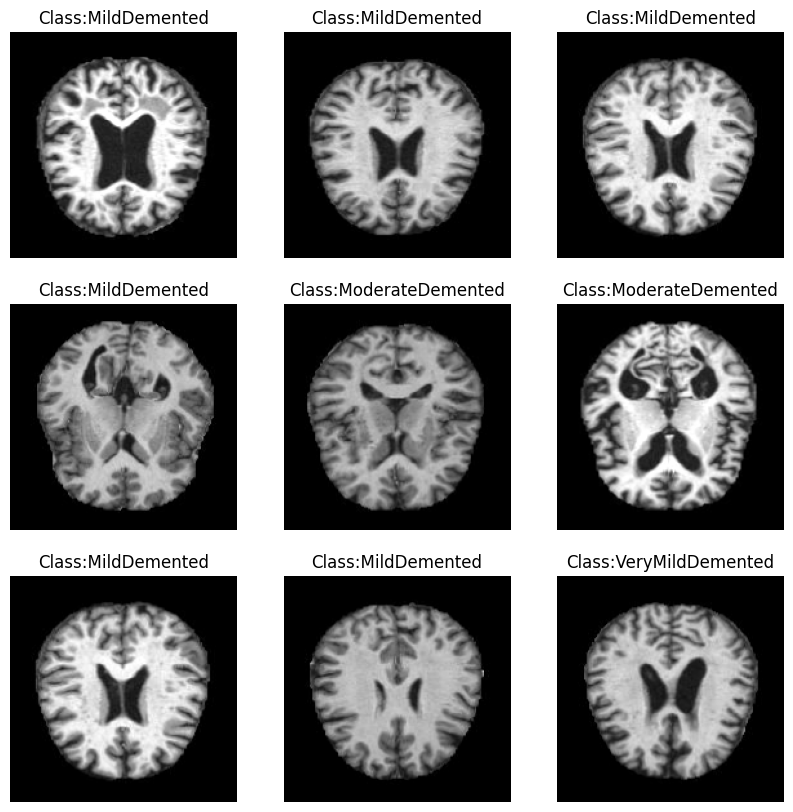

In [ ]:
import matplotlib.pyplot as plt
from random import randint
import numpy as np

def show_images(generator, y_pred=None):

    labels = dict(zip([0, 1, 2, 3], CLASSES))
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))

    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(
                labels[np.argmax(y[i])], labels[y_pred[i]]))
    plt.show()
show_images(train_dataset)

<BarContainer object of 4 artists>

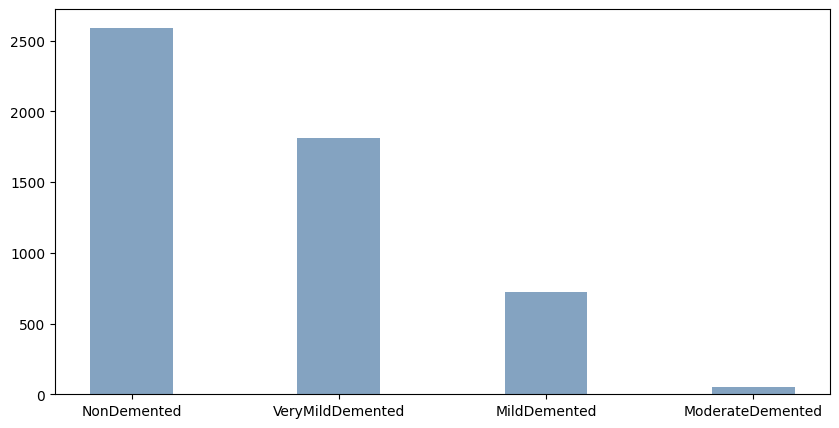

In [ ]:
data = {'NonDemented':      0,
        'VeryMildDemented': 0,
        'MildDemented':     0,
        'ModerateDemented': 0}
for cls in os.listdir(train_work_dir):
    for img in os.listdir(train_work_dir + '/' + cls):
        data[cls] = data[cls] + 1

keys = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

## Feature Engineering and Oversampling

In [ ]:
batch = next(train_dataset)
train_data, train_labels = batch

In [ ]:
print(train_data.shape, train_labels.shape)

(5182, 176, 176, 3) (5182, 4)


In [ ]:

sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(10368, 176, 176, 3) (10368, 4)


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

## CNN

In [ ]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [ ]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - acc: 0.9796 - auc: 0.9983 - loss: 0.0596 - val_acc: 0.9265 - val_auc: 0.9847 - val_loss: 0.2698
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - acc: 0.9822 - auc: 0.9993 - loss: 0.0502 - val_acc: 0.9216 - val_auc: 0.9874 - val_loss: 0.2591
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - acc: 0.9857 - auc: 0.9996 - loss: 0.0427 - val_acc: 0.9126 - val_auc: 0.9807 - val_loss: 0.3279
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - acc: 0.9853 - auc: 0.9991 - loss: 0.0458 - val_acc: 0.8939 - val_auc: 0.9775 - val_loss: 0.4168
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - acc: 0.9899 - auc: 0.9992 - loss: 0.0357 - val_acc: 0.9186 - val_auc: 0.9855 - val_loss: 0.3002
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - acc: 0.9799 - auc: 0.9984 - loss: 0.0651 - val_acc: 0.9271 - val_auc: 0.9861 - val_loss: 0.2730
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - acc: 0.9861 - auc: 0.9994 - loss: 0.048

In [ ]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9233 - auc: 0.9828 - loss: 0.3051
Loss:  0.29836755990982056
Accuracy:  0.9223722219467163


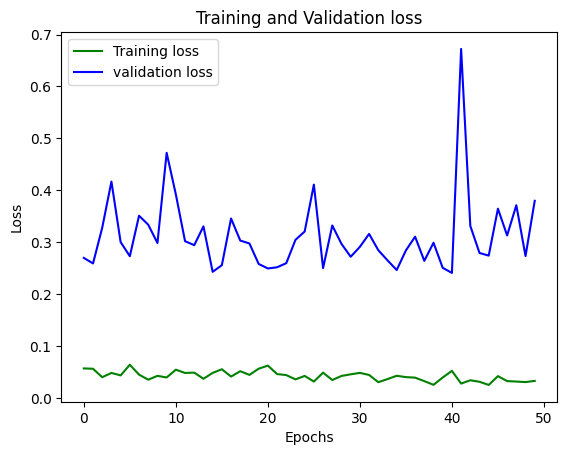

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

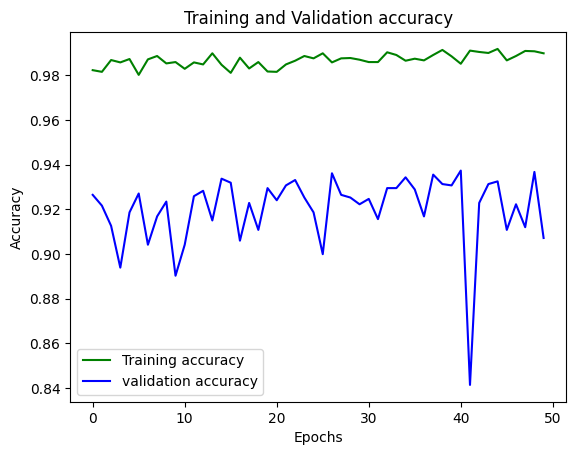

In [ ]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.save('my_model.h5')

In [ ]:
image_path="/content/9.jpg"
def print_predicted_class(image_path, model, CLASSES):
  img = image.load_img(image_path, target_size=(176, 176))
  image_array = img_to_array(img) / 255.0
  image_array = np.expand_dims(image_array, axis=0)
  predictions = model.predict(image_array)
  predicted_class_index = np.argmax(predictions)
  predicted_class_name = CLASSES[predicted_class_index]
  print(f"Predicted class: {predicted_class_name}")
print_predicted_class(image_path, model, CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: MildDemented


In [ ]:
image_path="/content/4.jpg"
print_predicted_class(image_path, model, CLASSES)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted class: VeryMildDemented
